In [2]:
import requests
import json
from pathlib import Path
import glob
import time
from pprint import pprint as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

In [3]:
def num_files(tier_code):
    files = glob.glob('./data/match_info/%d*.json'%tier_code)
    print(f"There exist {len(files):>5} files for tier_code {tier_code}")

In [4]:
def summoner_in_match(path):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    return summoner_list

In [5]:
def is_summoner(path, summoner_name):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    return (summoner_name in summoner_list)

In [6]:
def match_by_summoner(summoner_name):
    matches = []
    for tier in range(1,6):
        print(f"Searching Tier Code {tier}")
        num_matches = len(matches)
        files = glob.glob(f'./data/match_info/{tier}*.json')
        for file in files:
            if is_summoner(file, summoner_name):
                matches.append(file)
        if(num_matches != len(matches)):
            break
    return matches

In [7]:
def generate_sumlist():
    summoners = {}
    files = glob.glob('./data/match_info/*')
    files_num = len(files)
    count = 0
    start_time = time.time()
    for file in files:
        count = count + 1
        sum_list = summoner_in_match(file)
        for summonor in sum_list:
            if(summonor not in summoners):
                summoners[summonor] = 1
            else:
                summoners[summonor] = summoners[summonor] + 1
        print(f'{count}/{files_num}', end = '\r')
    print(time.time()-start_time)
    return summoners

In [167]:
def pts_extracter(match_id, summoner_name):
    timeline_path = f'./data/match_timeline/{match_id}.json'
    info_path = f'./data/match_info/{match_id}.json'
    tl = Path(timeline_path).read_bytes()
    tl_dic = json.loads(tl.decode())
    info = Path(info_path).read_bytes()
    info_dic = json.loads(info.decode())
    
    ingameId = 0
    for parts in info_dic['participantIdentities']:
        if(parts['player']['summonerName'] == summoner_name):
            ingameId = parts['participantId']
            break
    x = []
    y = []
    count = 0
    for frame in tl_dic['frames']:
        if count > 10:
            break
        try:
            x.append(frame['participantFrames'][str(ingameId)]['position']['x'])
            y.append(frame['participantFrames'][str(ingameId)]['position']['y'])
            for event in frame['events']:
                if (event['type'] == 'CHAMPION_KILL'):
                    if((event['killerId'] == ingameId) or (event['victimId'] == ingameId) or (ingameId in event['assistingParticipantIds'])):
                        x.append(event['position']['x'])
                        y.append(event['position']['y'])
        except:
            pass
        count += 1
    return x,y

In [165]:
def heatmap(x, y, s, bins):
    heatmap, xedge, yedge = np.histogram2d(x, y, range = [[0, 15000], [0, 15000]], bins=bins)    
    heatmap = gaussian_filter(heatmap, sigma=s)
    return heatmap.T

def show_heat_scatter(x,y,s, bins = 500):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig = plt.figure(figsize=(5,10))
    extent = [0,15000,0,15000]
    
    axs[0].plot(x, y, 'b.', markersize=2)
    axs[0].set_xlim([0, 15000])
    axs[0].set_ylim([0, 15000])
    axs[0].set_title("Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[0].imshow(img, zorder=0, extent=extent)

    heat = heatmap(x, y, s, bins)
    axs[1].imshow(heat, extent = extent, origin='lower', cmap=cm.jet)
    
    axs[1].set_title("Smoothing with  $\sigma$ = %d" % s)
    plt.show()

In [10]:
def get_itemname(items_dic, item_id):
    try:
        return items_dic['data'][f'{item_id}']['name']
    except:
        return (f"INVALID_ITEM(id : {item_id})")

In [11]:
#destroy, undo, purchsed, sold
def item_tech(match_id, part_id):
    tl = Path(f"./data/match_timeline/{match_id}.json").read_bytes()
    tl_dic = json.loads(tl.decode())
    
    #local
    #items = Path("./data/item_cdn.json").read_bytes()
    #items_dic = json.loads(items.decode())
    
    #online
    version = "10.16.1"
    items_dic = (requests.get(f"http://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/item.json")).json()
    
    inventory = []
    minutes = 0
    for frame in tl_dic['frames']:
        past_inv = inventory.copy()
        if len(frame['events']) == 0:
            continue
        else:
            for event in frame['events']:
                try: 
                    if event['participantId'] == part_id:
                        event_time = time.strftime("%M:%S", time.gmtime(event['timestamp']/1000))
                        if event['type'] == "ITEM_PURCHASED":
                            inventory.append(event["itemId"])
                            #print(f'\t{event_time}  Purchased {get_itemname(items_dic, event["itemId"])}')
                        elif event['type'] == "ITEM_SOLD":
                            del inventory[inventory.index(event["itemId"])]
                            print(f'\t- {event_time}  Sold {get_itemname(items_dic, event["itemId"])} ', end ='')
                            print(list(map(lambda x : get_itemname(items_dic, x), inventory)))
                        elif event['type'] == "ITEM_DESTROYED":
                            del inventory[inventory.index(event["itemId"])]
                            #print(f'\t{event_time}  Destroyed {get_itemname(items_dic, event["itemId"])}')
                        elif event['type'] == "ITEM_UNDO":
                            inventory.append(event["afterId"])
                            del inventory[inventory.index(event["beforeId"])]
                            #print(f'\t{event_time}  Undo {get_itemname(items_dic, event["beforeId"])} to {get_itemname(items_dic, event["afterId"])}')
                        else:
                            continue
                    else:
                        continue
                except:
                    pass
        minutes = minutes + 1
        while(0 in inventory):
            del inventory[inventory.index(0)]
        if (past_inv != inventory):
            print(f"- {minutes} min : ", end ='')
            print(list(map(lambda x : get_itemname(items_dic, x), inventory)))

In [72]:
for i in range(1,6):
    num_files(i)

There exist  1199 files for tier_code 1
There exist   956 files for tier_code 2
There exist     0 files for tier_code 3
There exist     0 files for tier_code 4
There exist     0 files for tier_code 5


In [87]:
files = glob.glob('./data/match_info/1*.json')
summoner_dict = {}
start_time = time.time()
for file in files:
    summoners = summoner_in_match(file)
    for summoner in summoners:
        if summoner in summoner_dict:
            summoner_dict[summoner] += 1
        else:
            summoner_dict[summoner] = 1
print(time.time()-start_time)

0.43660402297973633


In [102]:
over_50_summoners = [key for key in summoner_dict if summoner_dict[key] > 50]

In [195]:
target_summoner = over_50_summoners[11]
mts = match_by_summoner(target_summoner)
print(f'There exist {len(mts)} matches')

Searching Tier Code 1
There exist 100 matches


summoner name : 두시두시


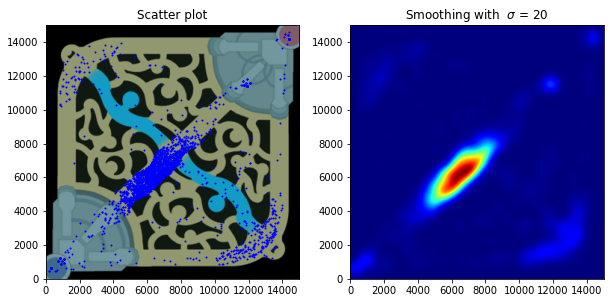

<Figure size 360x720 with 0 Axes>

In [196]:
x = []
y = []
for index in range(len(mts)):
    tmp_x,tmp_y = pts_extracter(mts[index][18:-5], target_summoner)
    x += tmp_x
    y += tmp_y
print(f"summoner name : {target_summoner}")
show_heat_scatter(x,y,20,1000)

In [192]:
# item_tech(mts[1][18:-5],1)